In [1]:
from __future__ import print_function

from IPython import display

import math
import matplotlib
import sklearn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import radians, cos, sin, arcsin, arccos, sqrt, pi, arctan2, degrees, arctan

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
tqdm.pandas(tqdm_notebook)

from joblib import dump, load

from natsort import natsorted
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import metrics

pd.options.display.max_rows = 10

In [2]:

def haversine(lat1, lon1, lat2, lon2):
    #ensure using numpy and not math, or pandas series cannot be passed
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a))
    r = 6378.137 ##radius of earth km
    return c * r

def compute_dist(df):
    next_df = df.shift(1)
    dist = haversine(df.iloc[:,0], df.iloc[:,1],
                    next_df.iloc[:,0], next_df.iloc[:,1])
    return dist

def compute_time(df):
    next_df = df.shift(1)
#     df["time"] = pd.to_datetime(df["time_utc"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise')
    timedelt = df["time"] - next_df["time"]
    return timedelt

def compute_speed(df):
    kinematics = df.copy()
    kinematics["distance_travelled"] = compute_dist(kinematics[["latitude", "longitude"]].astype(float)).values
    kinematics["time_elapsed"] = compute_time(kinematics).values
    kinematics["time_elapsed_seconds"] = kinematics["time_elapsed"]/np.timedelta64(1,'s')
    kinematics["speed m/s"] = (kinematics["distance_travelled"]*1000)/kinematics["time_elapsed_seconds"]
    kinematics["speed kmh"] = kinematics["speed m/s"]*3.6
    kinematics["bearing"] = compute_bearing(kinematics[["latitude", "longitude"]].astype(float))
    kinematics['bearing_diff'] = compute_bearing_diff(kinematics)
    kinematics["rate_of_turn"] = kinematics["bearing_diff"]/kinematics["time_elapsed_seconds"]
    kinematics["acceleration"] = (speed_diff(kinematics["speed m/s"])) /kinematics["time_elapsed_seconds"]
    kinematics.drop(columns = ['time_elapsed'], inplace = True)
    kinematics.fillna(0, inplace = True)
#     df["distance_travelled"] = kinematics["distance_travelled"].values
#     df["speed kmh"] = kinematics["speed kmh"].values
    return kinematics

def compute_bearing(df):
    next_df = df.shift(1)
    bear = cal_bearing(df.iloc[:,0], df.iloc[:,1],
                    next_df.iloc[:,0], next_df.iloc[:,1])
    return bear

def bearing_diff(bearing, prev_bearing):
    
    """
    Calculates the absolute difference between two angles
    Parameters
      bearing: bearing in degrees of the first angle
      prev_bearing: bearing in degrees of the second angle
    Returns the difference in degrees as a float
    """

    # if bearing - prev_bearing <=180 then taking the absolute difference is correct
    if bearing - prev_bearing <= 180:
        bearing_diff = abs(bearing - prev_bearing)
    # otherwise if bearing is larger than previous_bearing the total difference is the prev_bearing plus the difference
    # between 360 and the bearing
    elif bearing > prev_bearing:
        bearing_diff = prev_bearing + (360 - bearing)
    # otherwise if prev_bearing is larger than bearing the total difference is the bearing plus the difference 
    # between 360 and the prev_bearing
    elif prev_bearing > bearing:
        bearing_diff = bearing + (360 - prev_bearing)
    # in all other cases take the absolute difference
    else:
        bearing_diff = abs(bearing - prev_bearing)

    return bearing_diff

def cal_bearing(lat1, lon1, lat2, lon2):
    """
    Calculates the bearing between two points using the formula
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    """
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1

    x = sin(dlon) * cos(lat2)
    y1 = cos(lat1) * sin(lat2)
    y2 = sin(lat1) * cos(lat2) * cos(dlon)
    y = y1 - y2

    initial_bearing = arctan2(x, y)

    initial_bearing = degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

def compute_bearing_diff(df):
    df1 = df.copy()
    df1["prev_bearing"] = df1["bearing"].shift(1)
    df1["bearing diff"] = df1.apply(lambda row: bearing_diff(row['bearing'],row['prev_bearing']),axis=1)
    return df1["bearing diff"]

def speed_diff(df):
    next_df = df.shift(1)
    diff = df - next_df
    return diff

def compute_speed(df):
    kinematics = df.copy()
    kinematics["distance_travelled"] = compute_dist(kinematics[["latitude", "longitude"]].astype(float)).values
    kinematics["time_elapsed"] = compute_time(kinematics).values
    kinematics["time_elapsed_seconds"] = kinematics["time_elapsed"]/np.timedelta64(1,'s')
    kinematics["speed m/s"] = (kinematics["distance_travelled"]*1000)/kinematics["time_elapsed_seconds"]
    kinematics["speed kmh"] = kinematics["speed m/s"]*3.6
    kinematics["bearing"] = compute_bearing(kinematics[["latitude", "longitude"]].astype(float))
    kinematics['bearing_diff'] = compute_bearing_diff(kinematics)
    kinematics["rate_of_turn"] = kinematics["bearing_diff"]/kinematics["time_elapsed_seconds"]
    kinematics["acceleration"] = (speed_diff(kinematics["speed m/s"])) /kinematics["time_elapsed_seconds"]
    kinematics.drop(columns = ['time_elapsed'], inplace = True)
    kinematics.fillna(0, inplace = True)
#     df["distance_travelled"] = kinematics["distance_travelled"].values
#     df["speed kmh"] = kinematics["speed kmh"].values
    return kinematics

In [3]:
df =  pd.read_csv('/mnt/hgfs/FYP/porto_cleaned_100000.csv', parse_dates = ['time'])

In [4]:
grouper = df.groupby('ID')

In [5]:
a = []
b = []
c = []
for name, val in tqdm(grouper):
    idx_grper = val.groupby(val['Unnamed: 0'].diff().ne(1).cumsum())
    for name2, taxi in idx_grper:
        a.append(len(taxi))
        b.append(name)
        c.append(taxi)

100%|██████████| 427/427 [00:22<00:00, 18.92it/s]


In [6]:
def time_to_dest(df):
    end_time = df['time'].iloc[-1]
    df['time_to_dest'] = (end_time - df['time']).dt.total_seconds().astype(int)
def set_dropoff(df):
    df['dropoff_latitude'] = df['latitude'].iloc[-1]
    df['dropoff_longitude'] = df['longitude'].iloc[-1]


In [8]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.layers.recurrent import LSTM,RNN
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [9]:
# from keras import backend as K
# import tensorflow as tf
def rmsle_K(y, y0):
    return K.sqrt(K.mean(K.square(tf.log1p(y) - tf.log1p(y0))))
def rmsletf(y_pred, y_true): 
    y_pred= tf.cast(y_pred, tf.float64) 
    y_true= tf.cast(y_true, tf.float64) 
    y_pred=tf.nn.relu(y_pred) 
    return np.abs(tf.sqrt(tf.reduce_mean(tf.squared_difference(tf.log1p(y_pred), tf.log1p(y_true)))))

In [26]:
for i, d in enumerate(c):
    if len(d) < 40:
        c.pop(i)

In [ ]:
d = []
for i, df in tqdm(enumerate(c)):
    df2 = compute_speed(c[i])
    time_to_dest(df2)
    set_dropoff(df2)
    df2['dist_to_dest'] = haversine(df2['latitude'].values, df2['longitude'].values, df2['dropoff_latitude'].values, df2['dropoff_longitude'].values)
    df2['pickup_weekday'] = df2['time'].dt.weekday
    df2['pickup_hour_weekofyear'] = df2['time'].dt.weekofyear
    df2['pickup_hour'] = df2['time'].dt.hour
    df2['pickup_minute'] = df2['time'].dt.minute
    df2['pickup_dt'] = (df2['time'] - df2['time'].min()).dt.total_seconds()
    df2['pickup_week_hour'] = df2['pickup_weekday'] * 24 + df2['pickup_hour']
    df2[['next_lat', 'next_lon']] = df2[['latitude', 'longitude']].shift(-5)
    d.append(df2)
    if i > 1000:
        break

In [28]:
for i in d:
    i.dropna(inplace = True)

In [29]:
x_data = []
for i in d:
    x_data.append(i.drop(['Unnamed: 0', 'time', 'ID', 'time_elapsed_seconds', 'time_to_dest', 'next_lat', 'next_lon'] ,axis =1))
y_data = []
for i in d:
    y_data.append(i[['time_to_dest']])
#     y_data.append(i[['next_lat', 'next_lon']])

In [30]:
x_data[1]

,longitude,latitude,distance_travelled,speed m/s,speed kmh,bearing,bearing_diff,rate_of_turn,acceleration,dropoff_latitude,dropoff_longitude,dist_to_dest,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour
84793,-8.572221,41.163489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.147379,-8.620299,4.410719,0,27,12,17,0.0,12
84794,-8.572203,41.163489,0.001508,0.050283,0.181019,270.000006,0.000000,0.000000,0.000000,41.147379,-8.620299,4.412098,0,27,12,17,30.0,12
84795,-8.572203,41.163498,0.001002,0.066792,0.240450,180.000000,90.000006,6.000000,0.001101,41.147379,-8.620299,4.412505,0,27,12,17,45.0,12
84796,-8.572338,41.163426,0.013865,0.924338,3.327616,54.684924,125.315076,8.354338,0.057170,41.147379,-8.620299,4.398911,0,27,12,18,60.0,12
84797,-8.573355,41.162940,0.100951,6.730079,24.228284,57.593666,2.908742,0.193916,0.387049,41.147379,-8.620299,4.299084,0,27,12,18,75.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84833,-8.608491,41.147577,0.124016,8.267730,29.763827,25.202977,4.986704,0.332447,-0.098898,41.147379,-8.620299,0.990058,0,27,12,27,615.0,12
84834,-8.608509,41.147523,0.006198,0.413182,1.487454,14.090466,11.112511,0.740834,-0.523637,41.147379,-8.620299,0.988435,0,27,12,27,630.0,12
84835,-8.608815,41.147316,0.034481,2.298736,8.275451,48.065133,33.974667,2.264978,0.125704,41.147379,-8.620299,0.962681,0,27,12,27,645.0,12
84836,-8.609040,41.147370,0.019796,1.319706,4.750940,107.677873,59.612739,3.974183,-0.065269,41.147379,-8.620299,0.943795,0,27,12,28,660.0,12


In [31]:
x_train = x_data[0:900]
x_test = x_data[900:]
y_train = y_data[0:900]
y_test = y_data[900:]

In [32]:
# sc = MinMaxScaler(feature_range=(-1,1))
scy = MinMaxScaler(feature_range=(-1,1))
sc = sklearn.preprocessing.StandardScaler()
# new_df= x_data[].reshape(x_data.shape[0],5)

sc.fit(pd.concat(x_train).values)
scy.fit(pd.concat(y_train).values)


MinMaxScaler(copy=True, feature_range=(-1, 1))

In [33]:
for i, data in enumerate(x_train):
    x_train[i] = sc.transform(data)
    
for i, data in enumerate(y_train):
    y_train[i] = scy.transform(data)

In [34]:
x_test = sc.transform(pd.concat(x_test).values)
y_test = scy.transform(pd.concat(y_test).values)

In [35]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, 18)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, 1)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            j = np.random.randint(len(x_train))
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(len(x_train[j]) - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train[j][idx:idx+sequence_length]
            y_batch[i] = y_train[j][idx:idx+sequence_length]
#             x_batch[i] = x_train[j][0:sequence_length]
#             y_batch[i] = y_train[j][0:sequence_length]
        
        
        yield (x_batch, y_batch)

In [36]:
batch_size = 256
sequence_length = 30

In [37]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)
x_batch, y_batch = next(generator)

In [38]:
print(x_batch.shape)
print(y_batch.shape)

(256, 30, 18)
(256, 30, 1)


In [ ]:
y_batch

In [115]:
import random

# c = list(zip(x_test, y_test))

# random.shuffle(c)

# x_test, y_test = zip(*c)


In [40]:
validation_data = (np.expand_dims(x_test, axis=0),
                   np.expand_dims(y_test, axis=0))

In [41]:
validation_data[1].shape

(1, 5831, 1)

In [42]:
validation_data[1]

array([[[-0.9027027 ],
        [-0.90540541],
        [-0.90810811],
        ...,
        [-0.98918919],
        [-0.9972973 ],
        [-1.        ]]])

In [49]:
model = Sequential()

# first layer
model.add(LSTM(units=300, input_shape=(None,18),return_sequences=True))
model.add(Dropout(0.2))

# second layer
# model.add(Dense(128, 1))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
# fourth dense layer
model.add(Dense(units=1))


model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['mae'])
model.summary()
          

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 300)         382800    
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 100)         160400    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 50)          30200     
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)          

In [113]:
grumodel = Sequential()

# first layer
grumodel.add(GRU(units=30, input_shape=(None,18),return_sequences=True))
grumodel.add(Dropout(0.2))

# second layer
# model.add(Dense(128, 1))
grumodel.add(GRU(units=15,return_sequences=True))
grumodel.add(Dropout(0.2))

# third layer
# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))

# fourth dense layer
grumodel.add(Dense(units=1))


grumodel.compile(loss='mean_absolute_error',optimizer='adam',metrics=['mae'])
grumodel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, None, 30)          4410      
_________________________________________________________________
dropout_14 (Dropout)         (None, None, 30)          0         
_________________________________________________________________
gru_9 (GRU)                  (None, None, 15)          2070      
_________________________________________________________________
dropout_15 (Dropout)         (None, None, 15)          0         
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           16        
Total params: 6,496
Trainable params: 6,496
Non-trainable params: 0
_________________________________________________________________


In [45]:
%load_ext tensorboard
!rm -rf ./logs/ 

In [46]:
# import datetime
# log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [50]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [ ]:
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

In [114]:
grumodel.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
 99/100 [============================>.] - ETA: 0s - loss: 0.3662 - mean_absolute_error: 0.3662
Epoch 00001: val_loss did not improve from 0.06693
100/100 [==============================] - 11s 112ms/step - loss: 0.3645 - mean_absolute_error: 0.3645 - val_loss: 0.1263 - val_mean_absolute_error: 0.1263
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.1625 - mean_absolute_error: 0.1625
Epoch 00002: val_loss did not improve from 0.06693
100/100 [==============================] - 7s 71ms/step - loss: 0.1622 - mean_absolute_error: 0.1622 - val_loss: 0.0864 - val_mean_absolute_error: 0.0864
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.1245 - mean_absolute_error: 0.1245
Epoch 00003: val_loss did not improve from 0.06693
100/100 [==============================] - 7s 72ms/step - loss: 0.1244 - mean_absolute_error: 0.1244 - val_loss: 0.0778 - val_mean_absolute_error: 0.0778
Epoch 4/20
 99/100 [============================>.] - ETA: 0s 

In [52]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [115]:
result = grumodel.evaluate(x=np.expand_dims(x_test, axis=0),
                        y=np.expand_dims(y_test, axis=0))

1/1 [==============================] - 1s 922ms/sample - loss: 0.0579 - mean_absolute_error: 0.0579


In [116]:
y_pred = grumodel.predict(np.expand_dims(x_test, axis=0))

In [117]:
y_pred_rescaled = scy.inverse_transform(y_pred[0])
y_test_rescaled = scy.inverse_transform(y_test)

In [118]:
y_pred_rescaled 

array([[887.0945 ],
       [817.132  ],
       [834.01074],
       ...,
       [406.79025],
       [400.96146],
       [418.9146 ]], dtype=float32)

In [119]:
y_test_rescaled 

array([[615.],
       [600.],
       [585.],
       ...,
       [135.],
       [ 90.],
       [ 75.]])

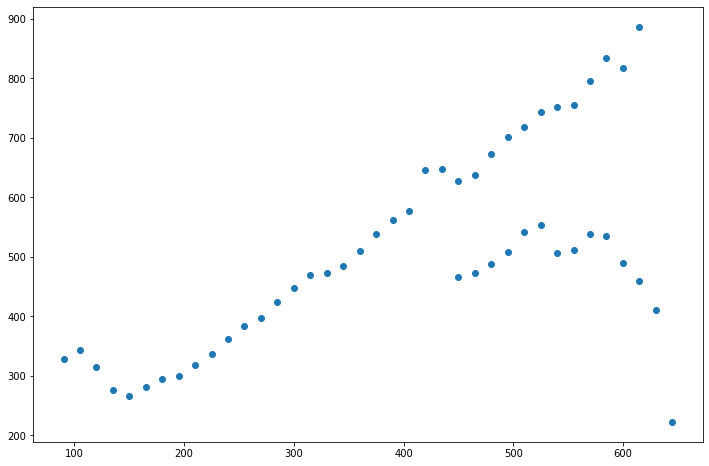

In [120]:
plt.figure(figsize=(12, 8))
plt.scatter(y_test_rescaled[0:50] , y_pred_rescaled[0:50])


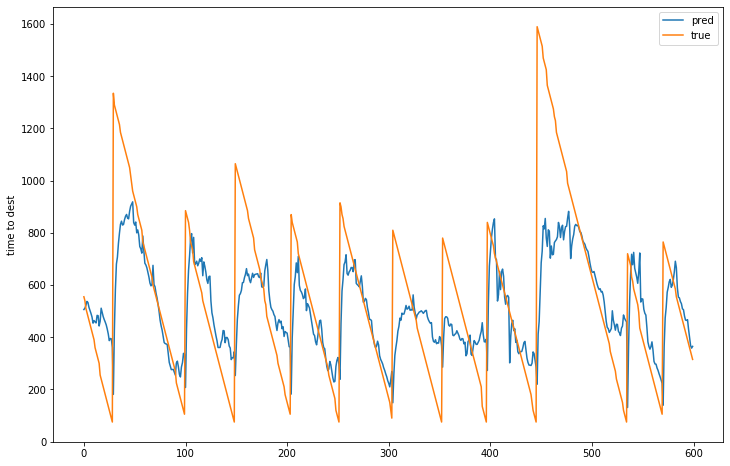

In [121]:
plt.figure(figsize=(12, 8))
plt.ylabel('time to dest')
# plt.plot(y_pred_rescaled, label = 'pred')
# plt.plot(y_test_rescaled, label = 'true')
plt.plot(y_pred_rescaled[1600:2200], label = 'pred')
plt.plot(y_test_rescaled[1600:2200], label = 'true')
plt.legend()

In [59]:
from sklearn.metrics import mean_absolute_error

In [128]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [139]:
mean_absolute_percentage_error(y_test_rescaled[1000:2000] , y_pred_rescaled[1000:2000] )

54.45833791614203

In [130]:
y_comb = np.append(y_test_rescaled, y_pred_rescaled, axis = 1)

In [137]:
y_comb

,0,1
0,75.0,418.914612
1,75.0,290.832245
2,75.0,250.879501
3,75.0,303.826294
4,75.0,361.262115
...,...,...
5826,5280.0,959.126099
5827,5295.0,816.700684
5828,5310.0,679.514465
5829,5325.0,551.043091


In [132]:
y_comb=y_comb[np.argsort(y_comb[:,0])]

In [133]:
y_comb = pd.DataFrame(y_comb)

In [134]:
for binn, group in y_comb.groupby(pd.cut(y_comb[0], 10)):
    print(mean_absolute_error(group[0] , group[1]))

147.40867321541654
226.32281098659573
590.537034478245
1057.224322945731
1429.4593584979023
1873.299970678381
1534.0864222935268
2029.0563853870738
2556.3961958451705
3589.873275756836


In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_comb[0:3000,0])
plt.plot(y_comb[0:3000,1])

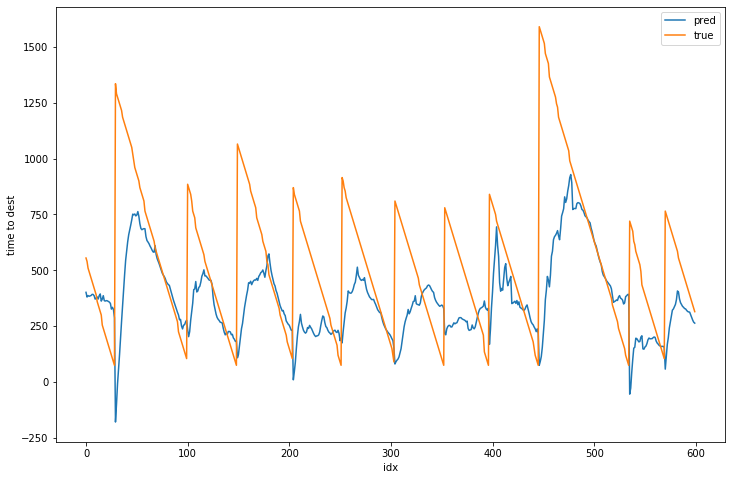

In [102]:
plt.figure(figsize=(12, 8))
plt.ylabel('time to dest')
plt.xlabel('idx')

plt.plot(y_pred_rescaled[1600:2200], label = 'pred')
plt.plot(y_test_rescaled[1600:2200], label = 'true')
plt.legend()

In [85]:
predicted_df = pd.DataFrame(data=y_pred_rescaled[0:,0:],index=[i for i in range(y_pred_rescaled.shape[0])],columns=['f'+str(i) for i in range(y_pred_rescaled.shape[1])])

actual_df = pd.DataFrame(data=y_test_rescaled[0:,0:],index=[i for i in range(y_test_rescaled.shape[0])],columns=['f'+str(i) for i in range(y_test_rescaled.shape[1])])


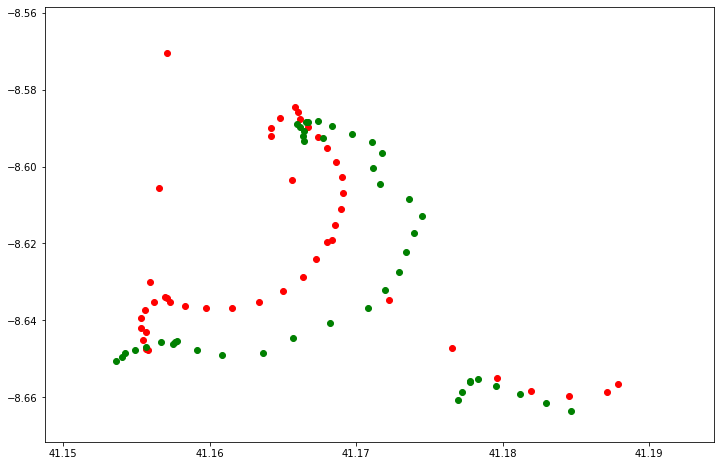

In [99]:
plt.figure(figsize=(12, 8))


plt.scatter(x=predicted_df['f0'][0:45],y=predicted_df['f1'][0:45],c='r',alpha=1)
plt.scatter(x=actual_df['f0'][0:45],y=actual_df['f1'][0:45],c='g',alpha=1)

In [96]:
predicted_df

,f0,f1
0,41.157089,-8.570538
1,41.156559,-8.605676
2,41.155952,-8.629983
3,41.155670,-8.643138
4,41.155777,-8.647686
...,...,...
5826,41.143692,-8.605156
5827,41.143353,-8.603797
5828,41.143044,-8.602565
5829,41.143341,-8.601144
